2D Laplace equation:
$$u_{xx} + u_{yy} = 0$$

Over the domain $[0, 1] \times [0, 1]$, with Dirichlet boundary conditions:
$$u(0, y) = -y^2$$
$$u(1, y) = 1-y^2$$
$$u(x, 0) = x^2$$
$$u(x, 1) = x^2 - 1$$

The solution we're aiming for is $$u(x, y) = x^2 - y^2$$.

In [1]:
import torch
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
import scipy.io
from scipy.stats import qmc

In [2]:
torch.set_default_dtype(torch.float)

torch.manual_seed(1234)
np.random.seed(1234)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
def plot3D_Matrix(x, y, u):
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(x, y, u ,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('u(x,y)')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  plt.show()

  
  ax = plt.axes(projection='3d')
  ax.plot_surface(x.numpy(), y.numpy(), u.numpy(),cmap="rainbow")
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('u(x,y)')
  plt.show()

In [4]:
def f_real(x, y):
    return x**2 - y**2

In [5]:
steps = 20000
lr = 0.001
layers = np.array([2, 32, 32, 1])

x_min = -1
x_max = 1
y_min = -1
y_max = 1

total_points_x = 200
total_points_y = 200

N_boundary = 4 # number of boundaries
N_u_boundary = 100 # number of points on each boundary
N_u = N_boundary * N_u_boundary
N_f = 10000 # number of collocation points

Data generation: based on https://github.com/hubertbaty/PINNS-PDE/blob/main/Pinns2d-heat-soft.ipynb

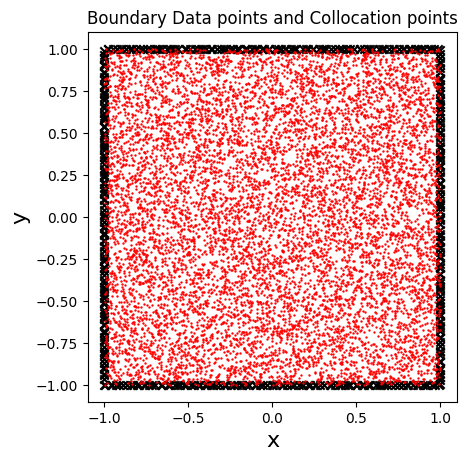

In [6]:
engine = qmc.LatinHypercube(d=1)
data = np.zeros([N_boundary, N_u_boundary, 3])

for i, j in zip(range(N_boundary), [-1, 1, -1, 1]):
    points = (engine.random(n = N_u_boundary) - 0.5) * 2
    if i < 2:
        data[i, :, 0] = j
        data[i, :, 1] = points[:, 0]
    else:
        data[i, :, 0] = points[:, 0]
        data[i, :, 1] = j

for j in range(N_u_boundary):    
    data[0, j, 2] = - data[0, j, 1]**2 + 1
    data[1, j, 2] = - data[1, j, 1]**2 + 1 

for i in range(N_u_boundary):
    data[2, i, 2] =  data[2, i, 0]**2 - 1
    data[3, i, 2] = data[3, i, 0]**2 - 1

data = data.reshape(-1, 3)
x_d, y_d, u_d = data[:, 0:1], data[:, 1:2], data[:, 2:3]

engine = qmc.LatinHypercube(d=2)
colloc = (engine.random(n = N_f) - 0.5) * 2

x_f, y_f = colloc[:, 0:1], colloc[:, 1:2]

plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=2., marker=".", c="r", label="CP")
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.axis("square")
plt.show()

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


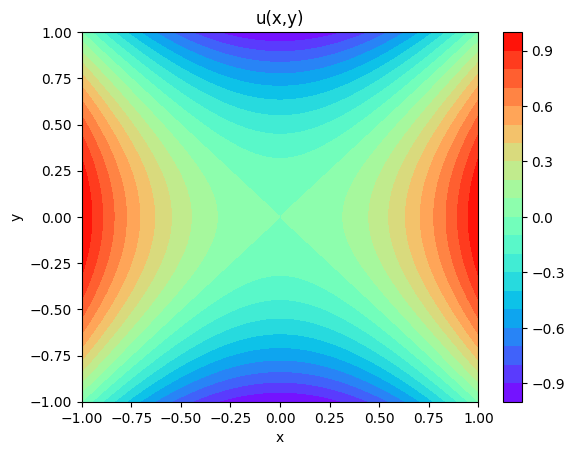

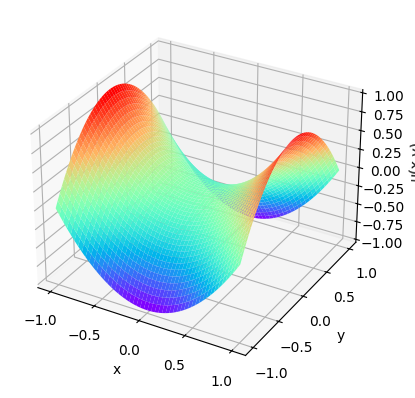

In [7]:
x = torch.linspace(x_min, x_max, total_points_x)
y = torch.linspace(y_min, y_max, total_points_y)

X, Y = torch.meshgrid(x, y)
U_real = f_real(X, Y)

plot3D_Matrix(X, Y, U_real)

In [8]:
# indexing nonsense - I don't know what this means

x_test = torch.hstack((X.transpose(1, 0).flatten()[:, None], Y.transpose(1, 0).flatten()[:, None]))
u_test = U_real.transpose(1, 0).flatten()[:, None]

x_test = x_test.float().to(device)
u_test = u_test.float().to(device)

x_train_boundary = torch.tensor(x_d).float().to(device)
y_train_boundary = torch.tensor(y_d).float().to(device)
u_train_boundary = torch.tensor(u_d).float().to(device)

x_train_colloc = torch.tensor(x_f).float().to(device)
y_train_colloc = torch.tensor(y_f).float().to(device)

In [9]:
class PINN(nn.Module):

    def __init__(self, layers):
        super().__init__()
        
        self.activation = nn.Sigmoid()
        self.loss_function = nn.MSELoss(reduction='mean')
        
        self.linears = nn.ModuleList([nn.Linear (layers[i], layers[i+1]) for i in range(len(layers)-1)])
                
        # Xavier initialization
        for i in range (len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain = 1.0)
            nn.init.zeros_(self.linears[i].bias.data)
            
    def forward(self, x, y):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)

        if not torch.is_tensor(y):
            y = torch.from_numpy(y)
        
        a = torch.cat((x.float(), y.float()), axis=1)

        
        # ugly way to make last layer linear
        for layer in self.linears[:-1]:
            z = layer(a)
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
    
    def loss_BC(self, x, y, u):
        return self.loss_function(self.forward(x, y), u)
    
    def loss_PDE(self, x, y):
        
        x_clone = x.clone().requires_grad_(True)
        y_clone = y.clone().requires_grad_(True)
        
        u = self.forward(x_clone, y_clone)
        u_x = autograd.grad(u.sum(), x_clone, create_graph=True)[0]
        u_y = autograd.grad(u.sum(), y_clone, create_graph=True)[0]
        u_xx = autograd.grad(u_x.sum(), x_clone, create_graph=True)[0]
        u_yy = autograd.grad(u_y.sum(), y_clone, create_graph=True)[0]

        f = u_xx + u_yy
        return self.loss_function(f, torch.zeros_like(f))
    
    def loss (self, x_BC, y_BC, u_BC, x_PDE, y_PDE):
        return self.loss_BC(x_BC, y_BC, u_BC) + self.loss_PDE(x_PDE, y_PDE)

In [10]:
model = PINN(layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [11]:
start_time = time.time()

train_losses = np.array([])
test_losses = np.array([])

for epoch in range(steps):
    optimizer.zero_grad()
    loss = model.loss(x_train_boundary, y_train_boundary, u_train_boundary, x_train_colloc, y_train_colloc)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        with torch.no_grad():
            # Add testing collocation points to make this work better
            test_loss = model.loss_BC(x_test[:, 0:1], x_test[:, 1:2], u_test)
        train_losses = np.append(train_losses, loss.item())
        test_losses = np.append(test_losses, test_loss.item())
        
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss {loss.item()}')
        
end_time = time.time()
print(f'Training time: {end_time - start_time}s')

Epoch 0, Loss 1.3424835205078125
Epoch 1000, Loss 0.40500813722610474
Epoch 2000, Loss 0.005717354826629162
Epoch 3000, Loss 0.0004139876982662827
Epoch 4000, Loss 0.00012487702770158648
Epoch 5000, Loss 6.4208208641503e-05
Epoch 6000, Loss 3.845387254841626e-05
Epoch 7000, Loss 2.5979181373259053e-05
Epoch 8000, Loss 1.8749118680716492e-05
Epoch 9000, Loss 1.3553146345657296e-05
Epoch 10000, Loss 1.0900257620960474e-05
Epoch 11000, Loss 1.0346235285396688e-05
Epoch 12000, Loss 9.548884008836467e-06
Epoch 13000, Loss 1.041504401655402e-05
Epoch 14000, Loss 3.2112409826368093e-05
Epoch 15000, Loss 8.674169293954037e-06
Epoch 16000, Loss 7.823508894944098e-06
Epoch 17000, Loss 3.5057259992754553e-06
Epoch 18000, Loss 6.673913958366029e-06
Epoch 19000, Loss 3.211805051250849e-06
Training time: 487.0105676651001s


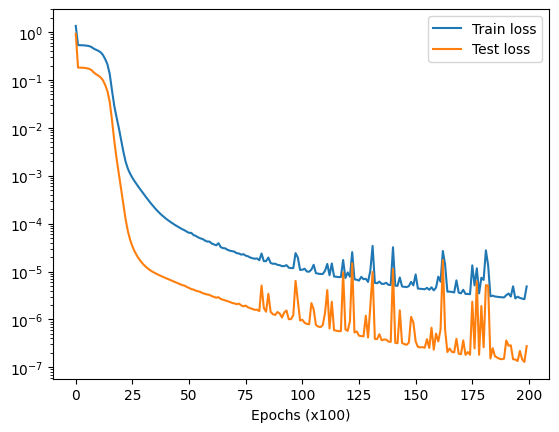

In [12]:
plt.semilogy(train_losses, label='Train loss')
plt.semilogy(test_losses, label='Test loss')
plt.xlabel('Epochs (x100)')
plt.legend()


Plots!

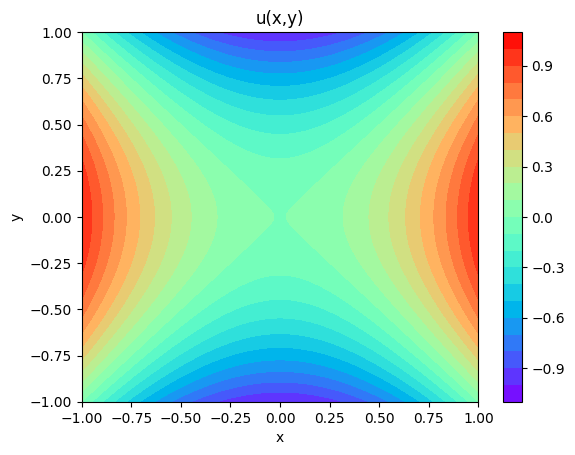

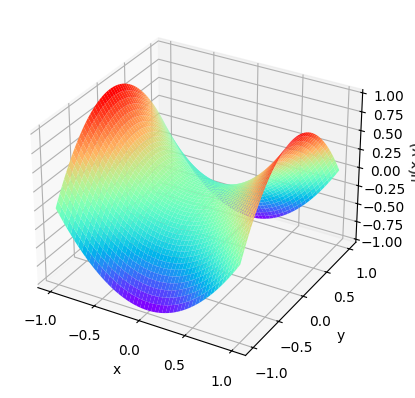

In [13]:
u_pred = model.forward(x_test[:, 0:1], x_test[:, 1:2]).cpu().detach()
u_pred = u_pred.reshape(total_points_x, total_points_y).transpose(1, 0)

# I think this transpose is correct? The shapes are weird
plot3D_Matrix(X, Y, u_pred)

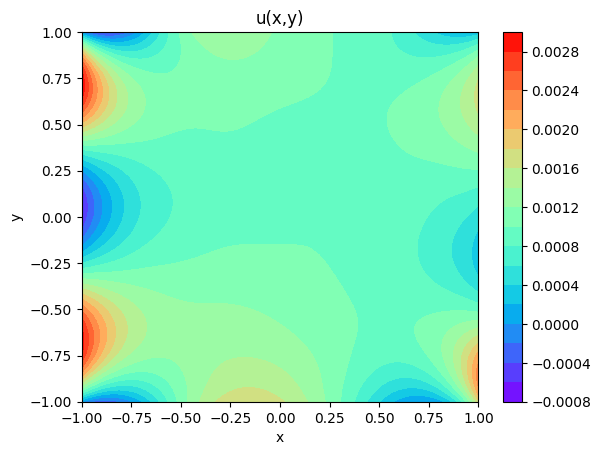

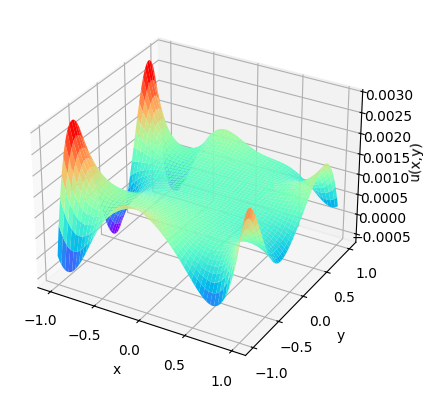

In [14]:
error = X ** 2 - Y ** 2 - u_pred

plot3D_Matrix(X, Y, error)

In [15]:
x = torch.linspace(x_min, x_max, total_points_x)
y = torch.linspace(y_min, y_max, total_points_y)

X, Y = np.meshgrid(x, y)

S = model.forward(X.flatten()[:, None], Y.flatten()[:, None]).cpu().detach().numpy()

[0, 49, 99, 149, 199]


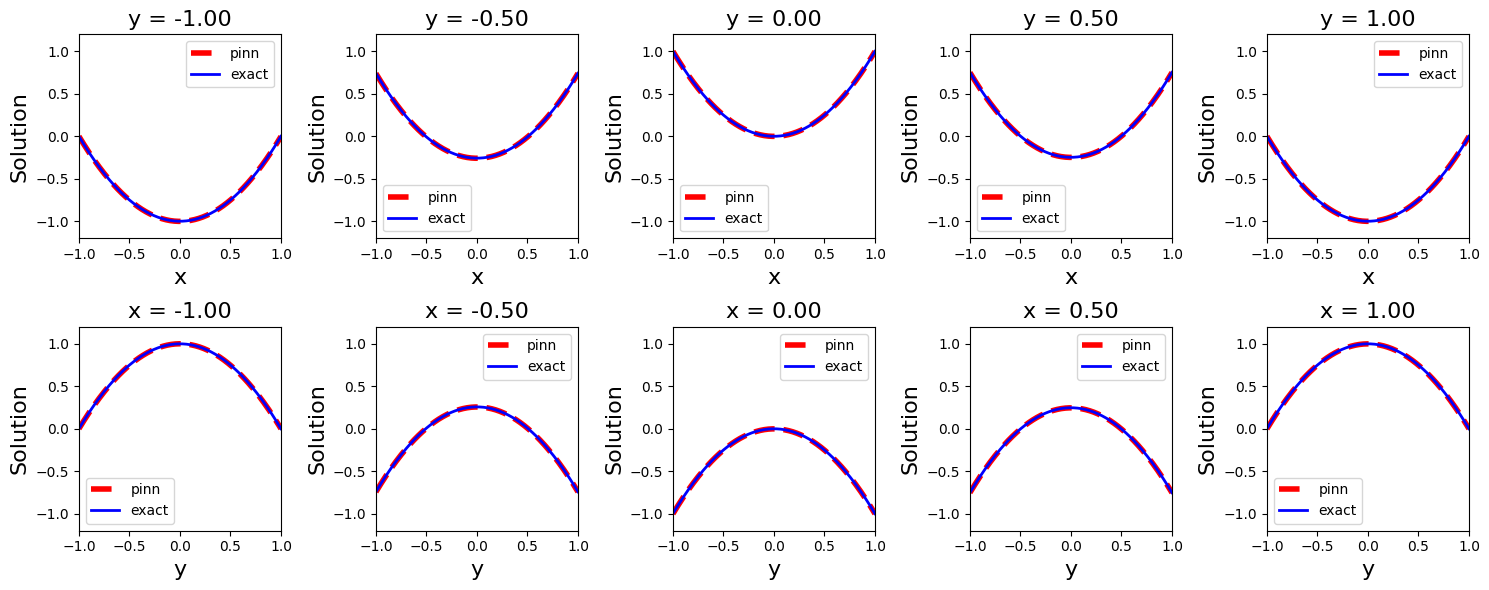

In [16]:
S_ = S.reshape(total_points_x, total_points_y)
T_ = X ** 2 - Y ** 2

height = 3
frames_val = np.array([-1., -0.5, 0., 0.5, 1.])
frames = [*map(int, (frames_val + 1)/2 * (200-1))]
fig = plt.figure("", figsize=(len(frames)*height, 2*height))

print(frames)

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), i+1)
    plt.title(f"y = {frames_val[i]:.2f}",fontsize=16)
    plt.plot(X[var_index, :], S_[var_index,:], "r--", lw=4., label="pinn")
    plt.plot(X[var_index, :], T_[var_index,:], "b", lw=2., label="exact")
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1., +1.)
    plt.xlabel("x",fontsize=16)
    plt.ylabel("Solution",fontsize=16)
    plt.tight_layout()
    plt.legend()

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), len(frames) + i+1)
    plt.title(f"x = {frames_val[i]:.2f}",fontsize=16)
    plt.plot(Y[:, var_index], S_[:,var_index], "r--", lw=4., label="pinn")
    plt.plot(Y[:, var_index], T_[:,var_index], "b", lw=2., label="exact")
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1., +1.)
    plt.xlabel("y",fontsize=16)
    plt.ylabel("Solution",fontsize=16)
    plt.tight_layout()
    plt.legend()

#plt.savefig("profiles.png")
plt.show()